In [16]:
import pandas as pd
import numpy as np 
import keras
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if __name__ == '__main__':


In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}


# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [3]:
# Data directory
DATADIR = '/content/drive/My Drive/UCI_HAR_Dataset'

#Loading the dataset

In [4]:
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/My Drive/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).values
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/My Drive/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).values

In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [8]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [9]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [10]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print("Number of timesteps ",timesteps)
print("Number of sensors used" , input_dim)
print("Number of time series " ,len(X_train))

Number of timesteps  128
Number of sensors used 9
Number of time series  7352


#LSTM-1

In [18]:
model = keras.models.Sequential([
      keras.layers.LSTM(32 , input_shape = ( timesteps , input_dim)),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(6 , activation= 'relu'),
      keras.layers.Softmax()
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
_________________________________________________________________
softmax_2 (Softmax)          (None, 6)                 0         
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size= 32 ,
          validation_data=(X_test, Y_test),
          epochs= 20 )

Epoch 1/20
230/230 [==============================] - 2s 11ms/step - loss: 1.4039 - accuracy: 0.4531 - val_loss: 1.4243 - val_accuracy: 0.3957
Epoch 2/20
230/230 [==============================] - 2s 9ms/step - loss: 1.3406 - accuracy: 0.4283 - val_loss: 1.3400 - val_accuracy: 0.4007
Epoch 3/20
230/230 [==============================] - 2s 9ms/step - loss: 1.1752 - accuracy: 0.5446 - val_loss: 1.1748 - val_accuracy: 0.5412
Epoch 4/20
230/230 [==============================] - 2s 9ms/step - loss: 0.9204 - accuracy: 0.6519 - val_loss: 1.1873 - val_accuracy: 0.5419
Epoch 5/20
230/230 [==============================] - 2s 9ms/step - loss: 0.7768 - accuracy: 0.6820 - val_loss: 0.8806 - val_accuracy: 0.5853
Epoch 6/20
230/230 [==============================] - 2s 9ms/step - loss: 0.7930 - accuracy: 0.6712 - val_loss: 0.7712 - val_accuracy: 0.6905
Epoch 7/20
230/230 [==============================] - 2s 9ms/step - loss: 0.7124 - accuracy: 0.7191 - val_loss: 0.7300 - val_accuracy: 0.7156
Epoch

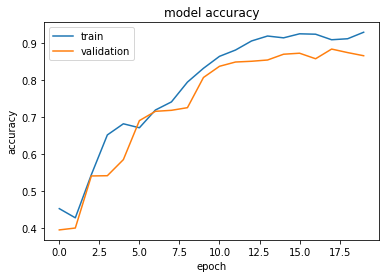

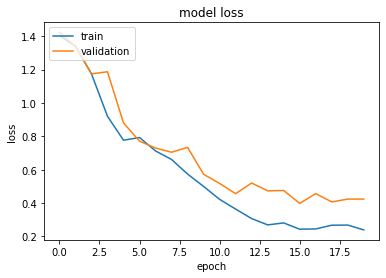

In [21]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING              494     0        0         0        0                    
SITTING             4       413      61        6        2                    
STANDING            0       122      382       23       2                    
WALKING             0       0        0         440      48                   
WALKING_DOWNSTAIRS  0       0        0         5        401                  
WALKING_UPSTAIRS    0       0        0         30       20                   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING              43                
SITTING             5                 
STANDING            3                 
WALKING             8                 
WALKING_DOWNSTAIRS  14                
WALKING_UPSTAIRS    421               


In [23]:
score = model.evaluate(X_test, Y_test)

93/93 [==============================] - 0s 5ms/step - loss: 0.4240 - accuracy: 0.8656


In [24]:
score

[0.42402851581573486, 0.8656260371208191]

#LSTM-2

In [27]:
model = keras.models.Sequential([
      keras.layers.LSTM(64 , input_shape = ( timesteps , input_dim) , return_sequences=True),
      keras.layers.Dropout(0.4),
      keras.layers.LSTM( 32 ),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(6 , activation= 'relu'),
      keras.layers.Softmax()
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
_________________________________________________________________
softmax_3 (Softmax)          (None, 6)                 0         
Total params: 31,558
Trainable params: 31,558
Non-trainable params: 0
__________________________________________________

In [28]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



In [29]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size= 32 ,
          validation_data=(X_test, Y_test),
          epochs= 20 )

Epoch 1/20
230/230 [==============================] - 4s 18ms/step - loss: 1.0789 - accuracy: 0.5506 - val_loss: 0.8734 - val_accuracy: 0.6298
Epoch 2/20
230/230 [==============================] - 3s 15ms/step - loss: 0.7648 - accuracy: 0.6848 - val_loss: 0.7082 - val_accuracy: 0.7557
Epoch 3/20
230/230 [==============================] - 3s 15ms/step - loss: 0.5657 - accuracy: 0.7991 - val_loss: 0.6679 - val_accuracy: 0.7221
Epoch 4/20
230/230 [==============================] - 3s 15ms/step - loss: 0.4364 - accuracy: 0.8489 - val_loss: 0.5096 - val_accuracy: 0.8174
Epoch 5/20
230/230 [==============================] - 3s 15ms/step - loss: 0.3407 - accuracy: 0.8923 - val_loss: 0.5066 - val_accuracy: 0.8395
Epoch 6/20
230/230 [==============================] - 3s 14ms/step - loss: 0.2655 - accuracy: 0.9147 - val_loss: 0.3940 - val_accuracy: 0.8751
Epoch 7/20
230/230 [==============================] - 3s 14ms/step - loss: 0.2123 - accuracy: 0.9287 - val_loss: 0.3183 - val_accuracy: 0.8897

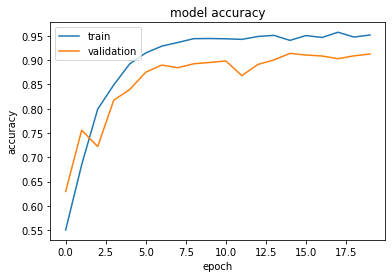

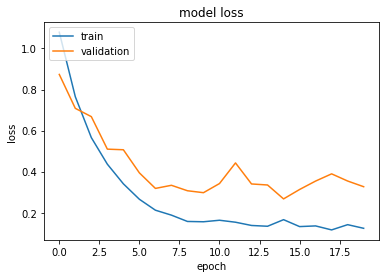

In [30]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [31]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING              536     0        0         0        0                    
SITTING             0       399      90        0        0                    
STANDING            0       89       442       1        0                    
WALKING             0       0        0         457      34                   
WALKING_DOWNSTAIRS  0       0        0         1        410                  
WALKING_UPSTAIRS    0       0        1         7        18                   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING              1                 
SITTING             2                 
STANDING            0                 
WALKING             5                 
WALKING_DOWNSTAIRS  9                 
WALKING_UPSTAIRS    445               


In [32]:
score = model.evaluate(X_test, Y_test)

93/93 [==============================] - 1s 7ms/step - loss: 0.3266 - accuracy: 0.9125


In [33]:
score

[0.3266490697860718, 0.9124533534049988]

#LSTM-3

In [41]:
model = keras.models.Sequential([
      keras.layers.LSTM(128 , input_shape = ( timesteps , input_dim) , return_sequences=True),
      keras.layers.Dropout(0.5),
      keras.layers.LSTM( 64 , return_sequences=True ),
      keras.layers.Dropout(0.4),
      keras.layers.LSTM( 32 ),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(6 , activation= 'relu'),
      keras.layers.Softmax()
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 128, 128)          70656     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 128, 64)           49408     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                

In [42]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [43]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size= 32 ,
          validation_data=(X_test, Y_test),
          epochs= 20 )

Epoch 1/20
230/230 [==============================] - 6s 25ms/step - loss: 0.9671 - accuracy: 0.6147 - val_loss: 0.6792 - val_accuracy: 0.7136
Epoch 2/20
230/230 [==============================] - 5s 21ms/step - loss: 0.5379 - accuracy: 0.8071 - val_loss: 0.5042 - val_accuracy: 0.8432
Epoch 3/20
230/230 [==============================] - 5s 21ms/step - loss: 0.3066 - accuracy: 0.9023 - val_loss: 0.5244 - val_accuracy: 0.8442
Epoch 4/20
230/230 [==============================] - 5s 21ms/step - loss: 0.2412 - accuracy: 0.9230 - val_loss: 0.3420 - val_accuracy: 0.8928
Epoch 5/20
230/230 [==============================] - 5s 21ms/step - loss: 0.1647 - accuracy: 0.9429 - val_loss: 0.3384 - val_accuracy: 0.9046
Epoch 6/20
230/230 [==============================] - 5s 21ms/step - loss: 0.3187 - accuracy: 0.8783 - val_loss: 0.3434 - val_accuracy: 0.8772
Epoch 7/20
230/230 [==============================] - 5s 21ms/step - loss: 0.1756 - accuracy: 0.9313 - val_loss: 0.3905 - val_accuracy: 0.8833

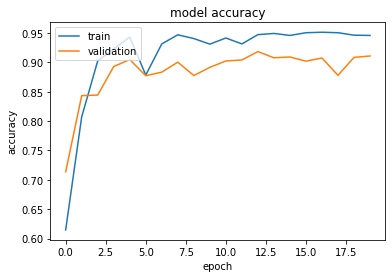

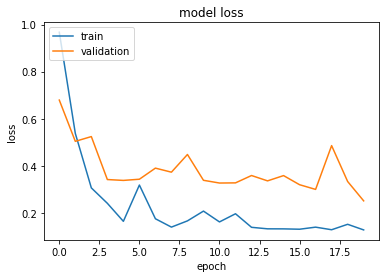

In [44]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [45]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING              533     0        0         0        0                    
SITTING             0       376      110       1        2                    
STANDING            0       98       433       1        0                    
WALKING             0       0        0         458      23                   
WALKING_DOWNSTAIRS  0       0        0         0        419                  
WALKING_UPSTAIRS    0       0        0         3        3                    

Pred                WALKING_UPSTAIRS  
True                                  
LAYING              4                 
SITTING             2                 
STANDING            0                 
WALKING             15                
WALKING_DOWNSTAIRS  1                 
WALKING_UPSTAIRS    465               


In [46]:
score = model.evaluate(X_test, Y_test)

93/93 [==============================] - 1s 10ms/step - loss: 0.2516 - accuracy: 0.9108


In [47]:
score

[0.25158625841140747, 0.9107567071914673]

#GRU

In [56]:
model = keras.models.Sequential([
      keras.layers.GRU( 128 , input_shape = ( timesteps , input_dim) , return_sequences=True),
      keras.layers.Dropout(0.5),
      keras.layers.GRU( 64 , return_sequences=True ),
      keras.layers.Dropout(0.4),
      keras.layers.GRU( 32 , return_sequences=True ),
      keras.layers.GRU( 16 ),
      keras.layers.Dense(6 , activation= 'relu'),
      keras.layers.Softmax()
])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 128, 128)          53376     
_________________________________________________________________
dropout_22 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
gru_8 (GRU)                  (None, 128, 64)           37248     
_________________________________________________________________
dropout_23 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
gru_9 (GRU)                  (None, 128, 32)           9408      
_________________________________________________________________
gru_10 (GRU)                 (None, 16)                2400      
_________________________________________________________________
dense_10 (Dense)             (None, 6)               

In [57]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [58]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size= 32 ,
          validation_data=(X_test, Y_test),
          epochs= 30 )

Epoch 1/30
230/230 [==============================] - 7s 30ms/step - loss: 1.1177 - accuracy: 0.5496 - val_loss: 0.8591 - val_accuracy: 0.6851
Epoch 2/30
230/230 [==============================] - 6s 25ms/step - loss: 0.4590 - accuracy: 0.8519 - val_loss: 0.4088 - val_accuracy: 0.8877
Epoch 3/30
230/230 [==============================] - 6s 25ms/step - loss: 0.2175 - accuracy: 0.9304 - val_loss: 0.2879 - val_accuracy: 0.9043
Epoch 4/30
230/230 [==============================] - 6s 25ms/step - loss: 0.1831 - accuracy: 0.9358 - val_loss: 0.3334 - val_accuracy: 0.8836
Epoch 5/30
230/230 [==============================] - 6s 25ms/step - loss: 0.1422 - accuracy: 0.9480 - val_loss: 0.3033 - val_accuracy: 0.9030
Epoch 6/30
230/230 [==============================] - 6s 25ms/step - loss: 0.1360 - accuracy: 0.9506 - val_loss: 0.2980 - val_accuracy: 0.9063
Epoch 7/30
230/230 [==============================] - 6s 25ms/step - loss: 0.1292 - accuracy: 0.9559 - val_loss: 0.2409 - val_accuracy: 0.9240

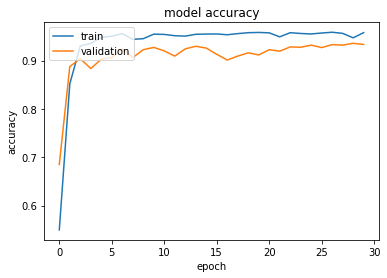

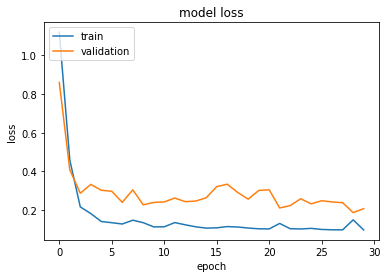

In [59]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [60]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING              537     0        0         0        0                    
SITTING             6       380      104       0        0                    
STANDING            0       57       475       0        0                    
WALKING             0       0        0         472      22                   
WALKING_DOWNSTAIRS  0       0        0         0        420                  
WALKING_UPSTAIRS    0       0        0         4        0                    

Pred                WALKING_UPSTAIRS  
True                                  
LAYING              0                 
SITTING             1                 
STANDING            0                 
WALKING             2                 
WALKING_DOWNSTAIRS  0                 
WALKING_UPSTAIRS    467               


In [61]:
score = model.evaluate(X_test, Y_test)

93/93 [==============================] - 1s 11ms/step - loss: 0.2082 - accuracy: 0.9335


In [63]:
score 

[0.20824724435806274, 0.9334917068481445]